In [2]:
import os

os.chdir('../..')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.metrics import *

In [4]:
models = ['AlexNet+demo+1', 'AlexNet+demo+2', 'AlexNet+standard',
          'AttNet+demo+1', 'AttNet+demo+2', 'AttNet+standard',
          'LeNet+demo+1', 'LeNet+demo+2', 'LeNet+standard',
          'ResNet+demo+1', 'ResNet+demo+2', 'ResNet+standard',
          'VGGNet+demo+1', 'VGGNet+demo+2', 'VGGNet+standard',
          'NewWavelet+demo+NN', 'NewWavelet+demo+2+NN', 'NewWavelet+NN',
          'Wavelet+demo+NN', 'Wavelet+demo+2+NN', 'Wavelet+NN']

base_models = ['AlexNet', 'AttNet', 'LeNet', 'ResNet', 'VGGNet', 'NewWavelet', 'Wavelet']

In [5]:
y_test = np.load(r"C://Mohit/Imperial/fyp-hearts/demo_experiment/output/exp4/data/y_test.npy", allow_pickle=True)

y_test_preds = []

for model in models:
    file = f"C://Mohit/Imperial/fyp-hearts/demo_experiment/output/exp4/models/{model}/y_test_pred.npy"
    y_pred = np.load(file, allow_pickle=True)
    y_pred = y_pred[:,np.where(np.any(y_test != 0, axis=0))[0]]
    y_test_preds += [y_pred]

y_test = y_test[:,np.where(np.any(y_test != 0, axis=0))[0]]

In [6]:
import pickle

with open(r"C:\Mohit\Imperial\fyp-hearts\demo_experiment\output\exp4\data\mlb.pkl", 'rb') as f:
    mlb = pickle.load(f).classes_

In [7]:
results = pd.DataFrame(index=models)
results['AUC'] = 0
results['F1 Score'] = 0
results['DUS'] = 0
results['Sensitivity'] = 0

In [8]:
def dus_calc(true, preds, beta=0.5):
    duses =[]

    for i in range(preds.shape[1]):
        predsx = preds[:,i]
        y_testx = true[:,i]
        
        tp = confusion_matrix(y_testx, (predsx>0.5).astype(int))[0][0]
        tn = confusion_matrix(y_testx, (predsx>0.5).astype(int))[1][1]
        fp = confusion_matrix(y_testx, (predsx>0.5).astype(int))[0][1]
        fn = confusion_matrix(y_testx, (predsx>0.5).astype(int))[1][0]

        dus = beta*roc_auc_score(y_testx, predsx) + (1-beta)*((tp+tn+fp)/(tp+tn+fp+fn))
        duses += [dus]
    
    dus = np.array(duses).mean()
    return dus

In [9]:
for i in range(len(models)):
    model = models[i]
    auc = roc_auc_score(y_test, y_test_preds[i])
    f1 = f1_score(y_test, (y_test_preds[i]>0.5).astype(int), average='macro')
    sensitivity = recall_score(y_test, (y_test_preds[i]>0.5).astype(int), average='macro')
    dus = dus_calc(y_test, y_test_preds[i])
    results.loc[model, 'AUC'] = auc
    results.loc[model, 'Sensitivity'] = sensitivity
    results.loc[model, 'F1 Score'] = f1
    results.loc[model, 'DUS'] = dus

results

,AUC,F1 Score,DUS,Sensitivity
AlexNet+demo+1,0.849186,0.135168,0.912737,0.123272
AlexNet+demo+2,0.769055,0.099490,0.872119,0.088086
AlexNet+standard,0.835229,0.149488,0.906054,0.139023
AttNet+demo+1,0.843444,0.182264,0.911799,0.179472
AttNet+demo+2,0.839705,0.153823,0.908391,0.146037
AttNet+standard,0.833475,0.153342,0.905217,0.139864
LeNet+demo+1,0.821170,0.082071,0.898098,0.077908
LeNet+demo+2,0.787351,0.114954,0.881228,0.104151
LeNet+standard,0.771802,0.104634,0.874065,0.097408
ResNet+demo+1,0.853133,0.161640,0.915657,0.149219


In [10]:
auc_vals = pd.DataFrame(columns=base_models)

for model in base_models:
    std = [i for i in models if 'demo' not in i]
    demo2 = [i for i in models if 'demo+2' in i]
    demo1 = [i for i in models if ('demo' in i and '2' not in i)]

auc_vals.loc['Standard'] = [results.loc[i, 'AUC'] for i in std]
auc_vals.loc['PREC'] = [results.loc[i, 'AUC'] for i in demo1]
auc_vals.loc['POC'] = [results.loc[i, 'AUC'] for i in demo2]

auc_vals.loc['PREC-Std (%)'] = (auc_vals.loc['PREC'] - auc_vals.loc['Standard'])/auc_vals.loc['Standard'] *100
auc_vals.loc['POC-Std (%)'] = (auc_vals.loc['POC'] - auc_vals.loc['Standard'])/auc_vals.loc['Standard'] * 100

auc_vals

,AlexNet,AttNet,LeNet,ResNet,VGGNet,NewWavelet,Wavelet
Standard,0.835229,0.833475,0.771802,0.808389,0.832769,0.774901,0.777870
PREC,0.849186,0.843444,0.821170,0.853133,0.840181,0.775443,0.797247
POC,0.769055,0.839705,0.787351,0.765643,0.822264,0.677806,0.699120
PREC-Std (%),1.671072,1.196128,6.396482,5.534940,0.890028,0.069993,2.491078
POC-Std (%),-7.922857,0.747456,2.014584,-5.287749,-1.261469,-12.529955,-10.123758


In [11]:
data = auc_vals.iloc[-2:].T

In [12]:
data

,PREC-Std (%),POC-Std (%)
AlexNet,1.671072,-7.922857
AttNet,1.196128,0.747456
LeNet,6.396482,2.014584
ResNet,5.534940,-5.287749
VGGNet,0.890028,-1.261469
NewWavelet,0.069993,-12.529955
Wavelet,2.491078,-10.123758


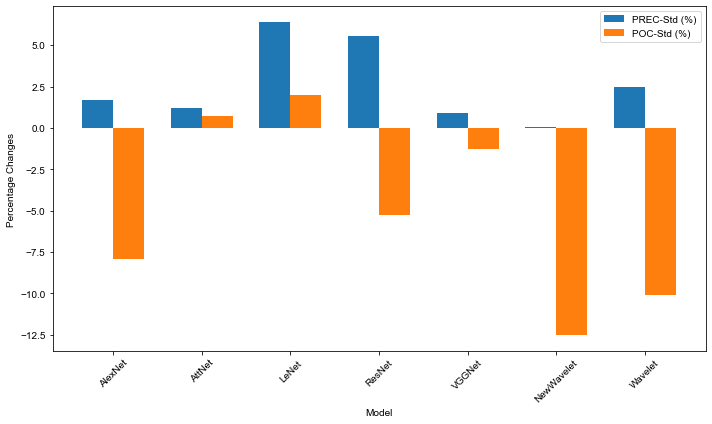

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Number of models
n_models = len(data)

# Bar width
bar_width = 0.35

# Index for the models
index = range(n_models)

# Bars for PREC-Std and POC-Std
prec_bars = ax.bar(index, data['PREC-Std (%)'], bar_width, label='PREC-Std (%)')
poc_bars = ax.bar([p + bar_width for p in index], data['POC-Std (%)'], bar_width, label='POC-Std (%)')

# Labeling
ax.set_xlabel('Model')
ax.set_ylabel('Percentage Changes')
# ax.set_title('Percentage Standard Deviations by Model')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(data.index)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

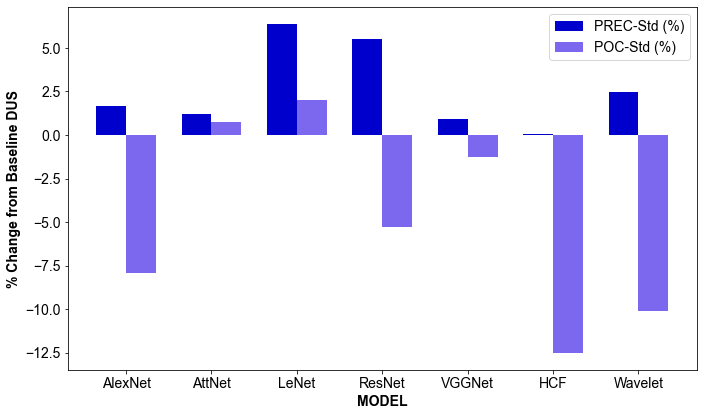

In [17]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 14  # Increase font size

data = dus_vals.iloc[-2:].T

fig, ax = plt.subplots(figsize=(10, 6))

# Number of models
n_models = len(data)

# Bar width
bar_width = 0.35

# Index for the models
index = list(range(n_models))

# Bars for PREC-Std and POC-Std
prec_bars = ax.bar(index, data['PREC-Std (%)'], bar_width, label='PREC-Std (%)', color="#0000cd")
poc_bars = ax.bar([p + bar_width for p in index], data['POC-Std (%)'], bar_width, label='POC-Std (%)', color="#7B68EE")

# Labeling
ax.set_xlabel('MODEL', fontweight='bold')
ax.set_ylabel(r'% Change from Baseline DUS', fontweight='bold')
# ax.set_title('Percentage Standard Deviations by Model')
ax.set_xticks([p + bar_width / 2 for p in index])

index = ['AlexNet', 'AttNet', 'LeNet', 'ResNet', 'VGGNet', 'HCF', 'Wavelet']
ax.set_xticklabels(index)
ax.legend()

# Show plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(r"C:\Users\agarw\OneDrive - Imperial College London\Year 4\Final Year Project\Report Images\dus_demo.png", dpi=1000)
plt.show()

In [15]:
dus_vals = pd.DataFrame(columns=base_models)

for model in base_models:
    std = [i for i in models if 'demo' not in i]
    demo2 = [i for i in models if 'demo+2' in i]
    demo1 = [i for i in models if ('demo' in i and '2' not in i)]

dus_vals.loc['Standard'] = [results.loc[i, 'AUC'] for i in std]
dus_vals.loc['PREC'] = [results.loc[i, 'AUC'] for i in demo1]
dus_vals.loc['POC'] = [results.loc[i, 'AUC'] for i in demo2]

dus_vals.loc['PREC-Std (%)'] = (dus_vals.loc['PREC'] - dus_vals.loc['Standard'])/dus_vals.loc['Standard'] *100
dus_vals.loc['POC-Std (%)'] = (dus_vals.loc['POC'] - dus_vals.loc['Standard'])/dus_vals.loc['Standard'] * 100

dus_vals

,AlexNet,AttNet,LeNet,ResNet,VGGNet,NewWavelet,Wavelet
Standard,0.835229,0.833475,0.771802,0.808389,0.832769,0.774901,0.777870
PREC,0.849186,0.843444,0.821170,0.853133,0.840181,0.775443,0.797247
POC,0.769055,0.839705,0.787351,0.765643,0.822264,0.677806,0.699120
PREC-Std (%),1.671072,1.196128,6.396482,5.534940,0.890028,0.069993,2.491078
POC-Std (%),-7.922857,0.747456,2.014584,-5.287749,-1.261469,-12.529955,-10.123758


In [123]:
dus_vals.loc['PREC-Std (%)'].mean(), dus_vals.loc['POC-Std (%)'].mean()

(2.607102869582206, -4.909106733518356)